In [192]:
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [44]:
def readData(location):
  if(location == 1):
    y_train_obs_A = pd.read_parquet('data/A/train_targets.parquet')
    X_test_est_A = pd.read_parquet('data/A/X_test_estimated.parquet')
    X_train_est_A = pd.read_parquet('data/A/X_train_estimated.parquet')
    X_train_obs_A = pd.read_parquet('data/A/X_train_observed.parquet')
    return y_train_obs_A, X_test_est_A, X_train_est_A, X_train_obs_A
  elif(location == 2):
    y_train_obs_B = pd.read_parquet('data/B/train_targets.parquet')
    X_test_est_B = pd.read_parquet('data/B/X_test_estimated.parquet' )
    X_train_est_B = pd.read_parquet('data/B/X_train_estimated.parquet')
    X_train_obs_B = pd.read_parquet('data/B/X_train_observed.parquet')
    return y_train_obs_B, X_test_est_B , X_train_est_B, X_train_obs_B
  else:
    y_train_obs_C = pd.read_parquet('data/C/train_targets.parquet')
    X_test_est_C = pd.read_parquet('data/C/X_test_estimated.parquet')
    X_train_est_C = pd.read_parquet('data/C/X_train_estimated.parquet')
    X_train_obs_C = pd.read_parquet('data/C/X_train_observed.parquet')
    X_c = pd.concat([X_train_est_C, X_train_obs_C])
    return y_train_obs_C, X_test_est_C, X_train_est_C, X_train_obs_C


In [45]:
y_a, X_test_A, X_train_A_est, X_train_A_obs = readData(1)

In [46]:
columns_with_nan_A_obs = X_train_A_obs.columns[X_train_A_obs.isna().any()].to_list()
X_train_A_obs.drop(columns=columns_with_nan_A_obs, inplace=True)

columns_with_nan_A_test_est = X_test_A.columns[X_test_A.isna().any()].to_list()
X_test_A.drop(columns=columns_with_nan_A_test_est, inplace=True)

columns_with_nan_A_train_est = X_train_A_est.columns[X_train_A_est.isna().any()].to_list()
X_train_A_est.drop(columns=columns_with_nan_A_train_est, inplace=True)

y_a = y_a.dropna()


In [47]:
X_train_A_obs.set_index('date_forecast', inplace=True)

X_train_A_est.set_index('date_forecast', inplace=True)

X_test_A.set_index('date_forecast', inplace=True)

y_a.set_index('time', inplace=True)


In [48]:
def make_hourly(unsampled_df, target_df):
    sampled_df = unsampled_df.resample('H').mean()
    sampled_df.index = sampled_df.index.floor('H')
    merged_df = sampled_df.merge(target_df, left_index=True, right_index=True, how='inner')
    return merged_df

In [215]:
merged_df_train_obs_A = make_hourly(X_train_A_obs, y_a)
merged_df_train_est_A = make_hourly(X_train_A_est, y_a)
merged_df_train_est_A = merged_df_train_est_A.dropna()
merged_df_train_obs_A = merged_df_train_est_A.dropna()
merged_df_train_obs_A.to_csv('train_obs.csv',index = True)
merged_df_train_est_A.to_csv('train_est.csv',index = True)

C:\Users\claxl\AppData\Local\Temp\ipykernel_29512\3041205111.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sampled_df = unsampled_df.resample('H').mean()


In [219]:
X_test_A = X_test_A.resample('H').mean()
X_test_A.index = X_test_A.index.floor('H')
X_test_A = X_test_A.dropna()
X_test_A.to_csv('X_test_A.csv',index = True)

In [56]:
features_name = [c for c in merged_df_train_obs_A.columns if c != 'pv_measurement']
target = 'pv_measurement'
X_A = merged_df_train_obs_A[features_name]
y_A = merged_df_train_obs_A[target]

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
2019-06-02 22:00:00,7.700,1.22825,0.000000,0.00,0.0,280.299988,0.000,0.000000,0.00,0.000000,...,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,0.00
2019-06-02 23:00:00,7.700,1.22350,0.000000,0.00,0.0,280.299988,0.000,0.000000,0.00,0.000000,...,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,0.00
2019-06-03 00:00:00,7.875,1.21975,0.000000,0.00,0.0,280.649994,0.000,0.000000,0.00,0.000000,...,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,0.00
2019-06-03 01:00:00,8.425,1.21800,208.649994,0.75,0.0,281.674988,0.300,526.775024,0.00,0.000000,...,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,0.00
2019-06-03 02:00:00,8.950,1.21800,32468.150391,23.10,0.0,282.500000,11.975,22068.949219,0.15,282.975006,...,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 20:00:00,5.800,1.28050,0.000000,0.00,0.0,275.799988,0.000,0.000000,0.00,0.000000,...,-29.704250,0.0,278.250000,47.050003,40105.472656,1.925,0.475,1.850,0.0,0.00
2022-10-20 21:00:00,5.575,1.28400,0.000000,0.00,0.0,275.200012,0.000,0.000000,0.00,0.000000,...,-33.860748,0.0,277.850006,19.500000,39001.398438,1.675,0.250,1.675,0.0,0.00
2022-10-20 22:00:00,5.350,1.28700,0.000000,0.00,0.0,274.600006,0.000,0.000000,0.00,0.000000,...,-36.270000,0.0,277.475006,9.700000,35336.726562,1.400,0.050,1.400,0.0,0.00
2022-10-20 23:00:00,5.200,1.29050,0.000000,0.00,0.0,274.174988,0.000,0.000000,0.00,0.000000,...,-36.614998,0.0,277.149994,4.525000,27164.625000,1.300,-0.175,1.300,0.0,0.00


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_A, y_A, test_size=0.1, shuffle = False)

In [66]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train.shape, y_test.shape

((26700,), (2967,))

### 1. Dimensionality Reduction (PCA)

Correlation between target and features

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


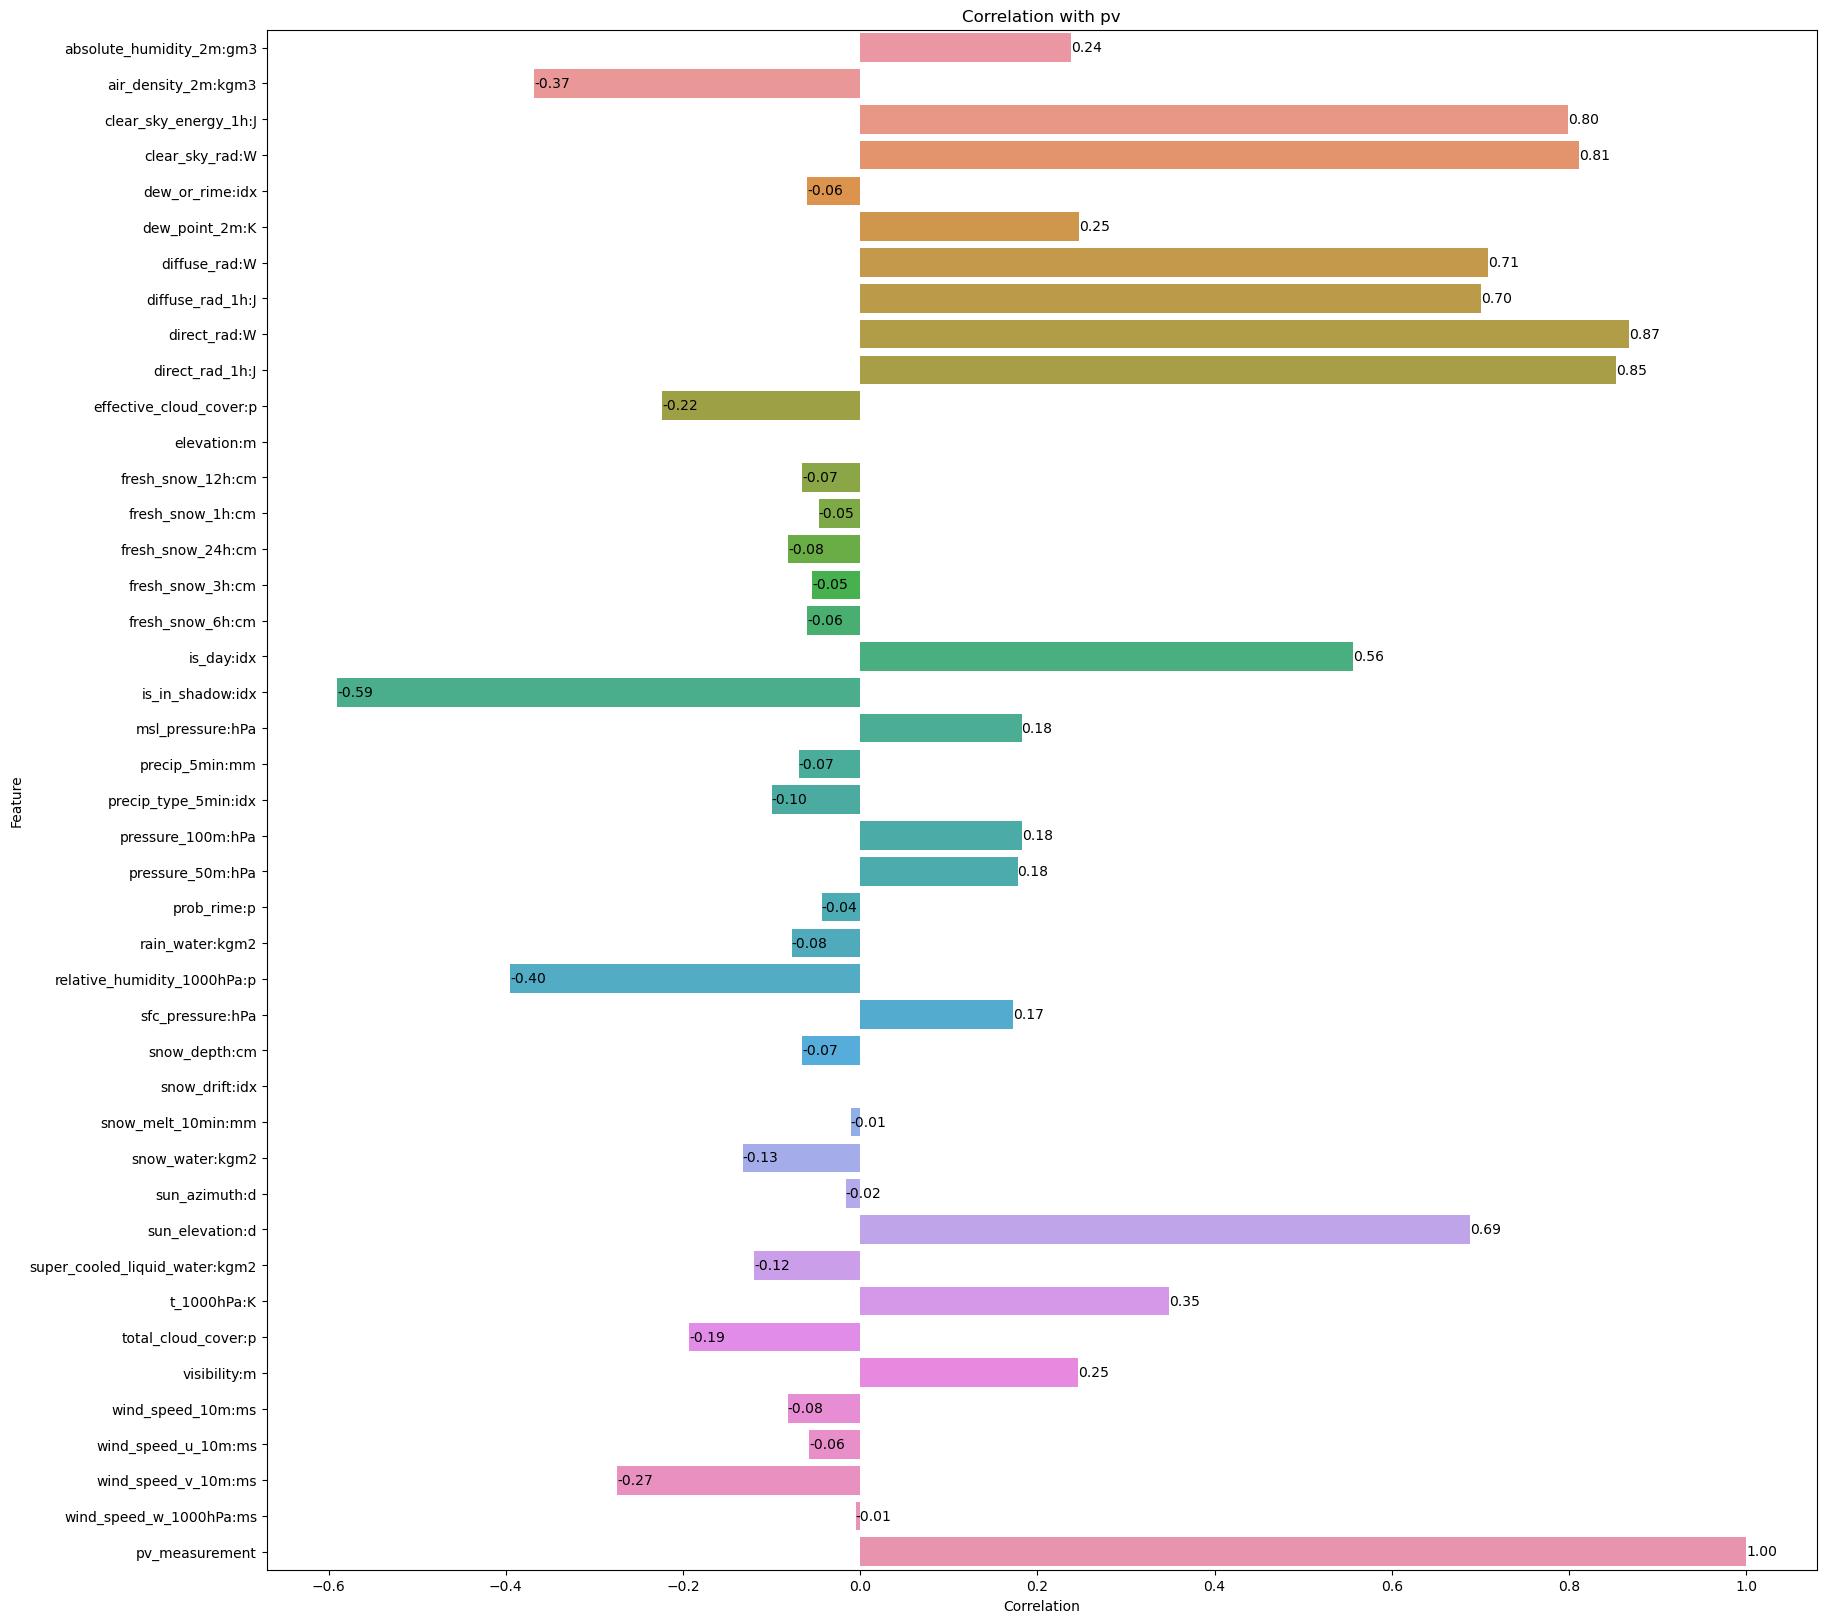

In [136]:


# Crea un dataframe di esempio con numeri nei nomi delle colonne


df = pd.concat([merged_df_train_obs_A, merged_df_train_est_A], ignore_index=True)


# Calcola la matrice di correlazione
correlation_matrix = df.corrwith(df[target])

plt.figure(figsize=(20, 20))
ax = sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index, orient='h')
plt.title('Correlation with pv')
plt.xlabel('Correlation')
plt.ylabel('Feature')

# Aggiungi i valori numerici alla fine delle barre
for p in ax.patches:
    width = p.get_width()
    plt.text(width, p.get_y() + p.get_height() / 2, f'{width:.2f}', ha='left', va='center')

plt.show()

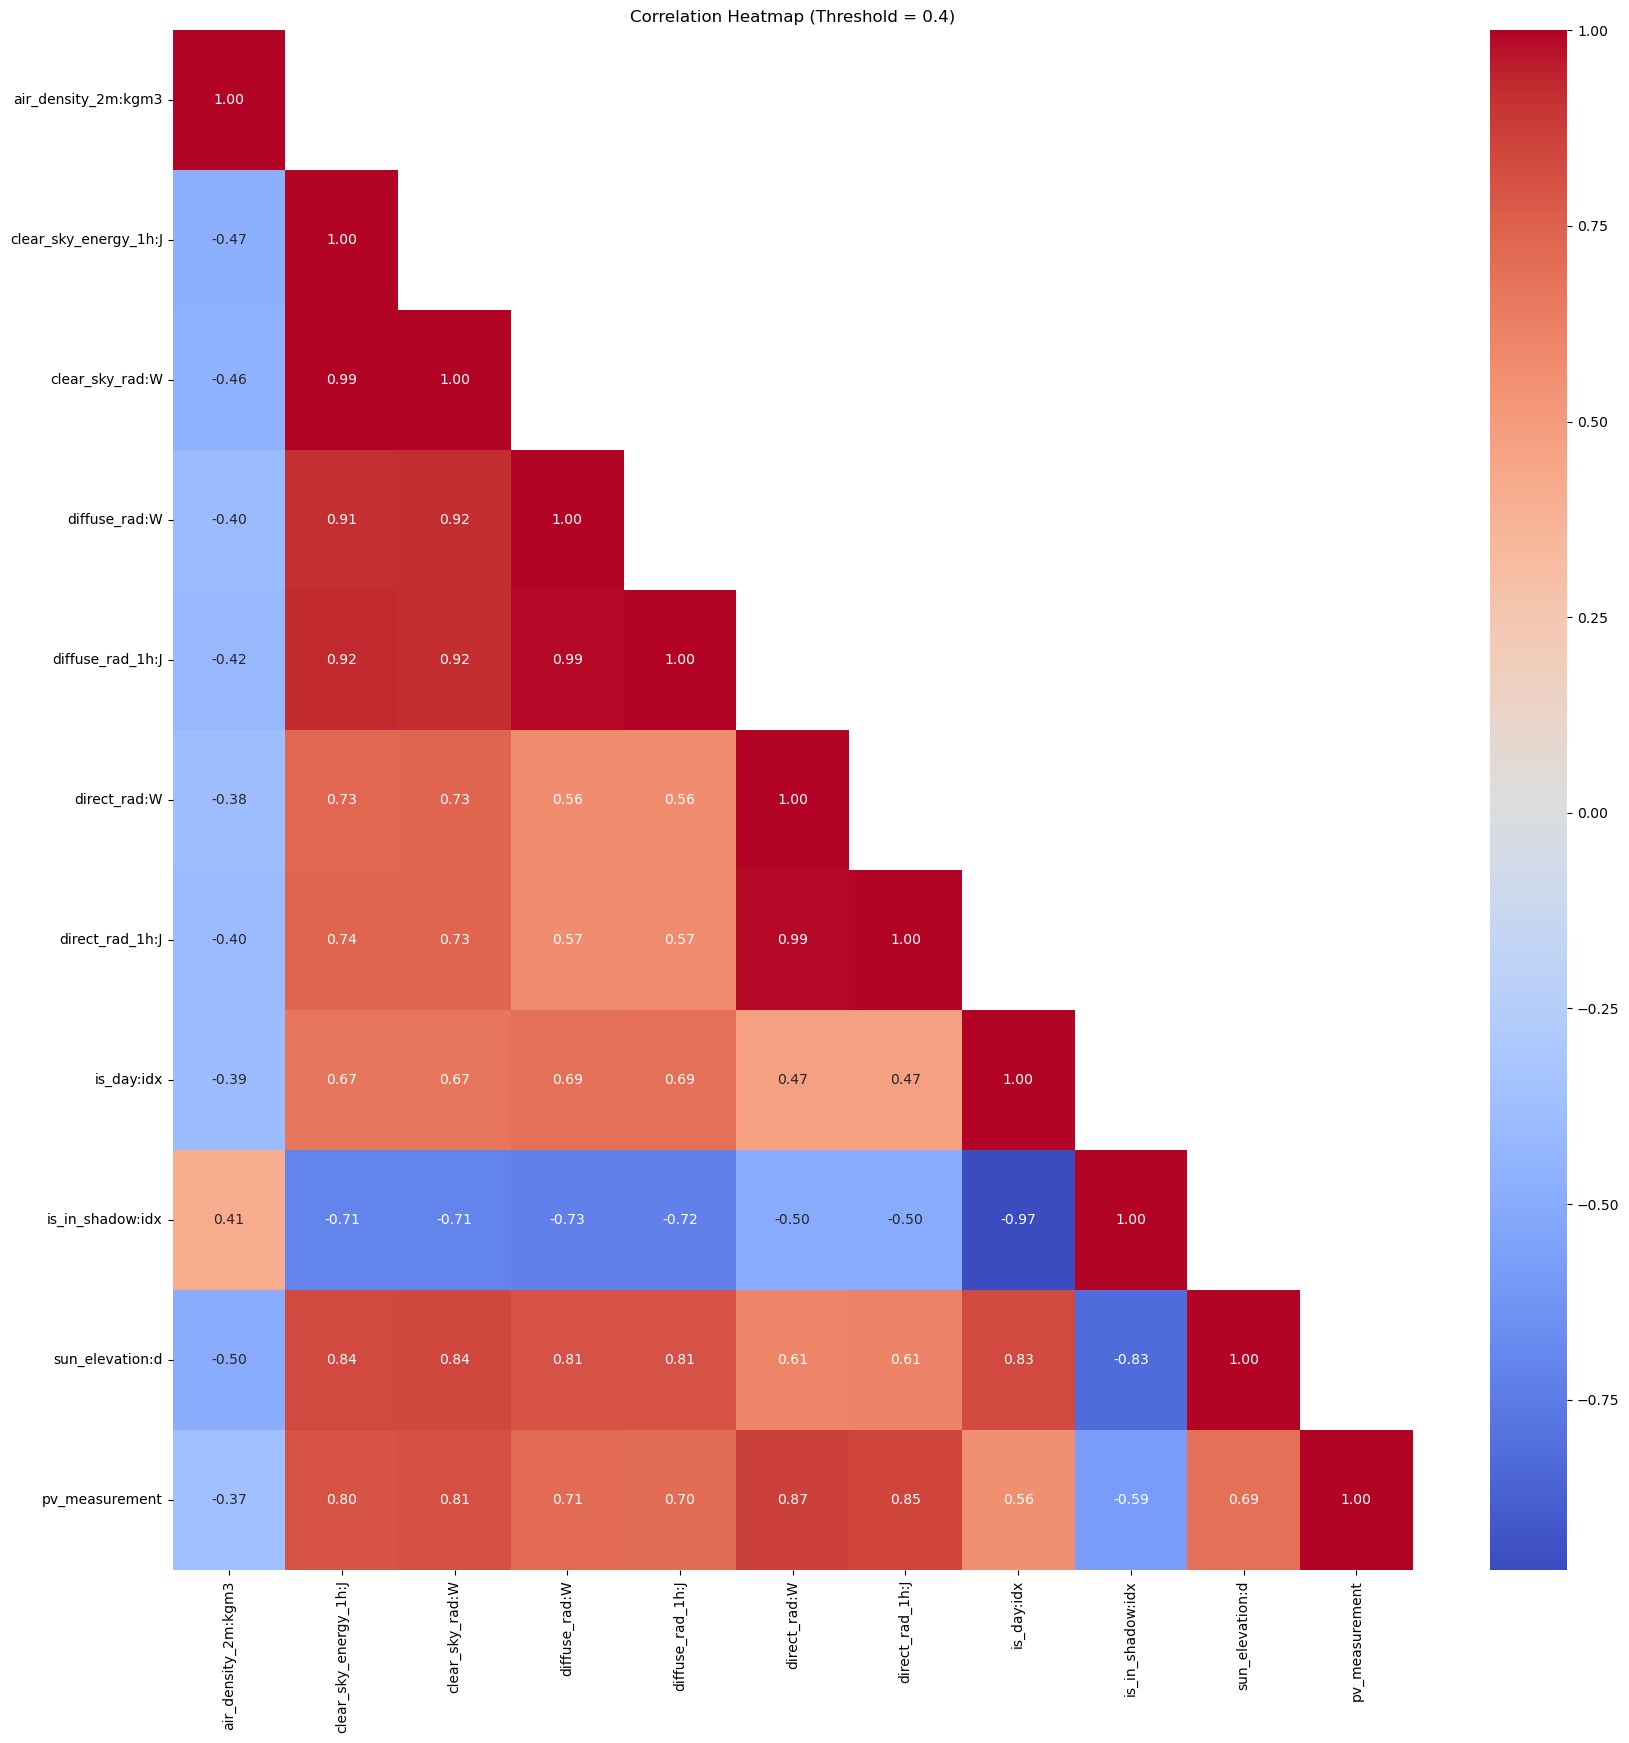

In [160]:

df = pd.concat([merged_df_train_obs_A, merged_df_train_est_A], ignore_index=True)

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Definisci la soglia
threshold = 0.4

# Trova le colonne da mantenere
columns_to_keep = correlation_matrix.columns[(correlation_matrix.abs() >= threshold).sum() >= 10]

# Seleziona solo le colonne che soddisfano il criterio
filtered_corr_matrix = correlation_matrix.loc[columns_to_keep, columns_to_keep]
mask_upper = np.triu(np.ones(filtered_corr_matrix.shape), k=1).astype(bool)

# Crea una heatmap della matrice di correlazione filtrata
plt.figure(figsize=(20, 20))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask_upper)
plt.title(f'Correlation Heatmap (Threshold = {threshold})')
plt.show()


In [198]:
df = X_train
to_keep_columns = filtered_corr_matrix.drop(columns=['pv_measurement'])
print(to_keep_columns.columns)
df = df[to_keep_columns.columns].to_numpy()

df.shape

Index(['air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d'],
      dtype='object')


(26700, 10)

In [199]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Crea un oggetto PCA
pca = PCA(n_components=5)

# Esegui la PCA
x_train_PCA = pca.fit_transform(scaled_data)
x_train_PCA.shape

(26700, 5)

In [200]:
df = X_test

df = df[to_keep_columns.columns].to_numpy()

df.shape

(2967, 10)

In [201]:
scaled_data = scaler.fit_transform(df)

# Crea un oggetto PCA
pca = PCA(n_components=5)

# Esegui la PCA
x_test_PCA = pca.fit_transform(scaled_data)
x_test_PCA.shape

(2967, 5)

In [214]:
forest_pca = RandomForestRegressor(n_estimators=100, max_depth=5).fit(x_train_PCA, y_train)
forest_pca_test_predictions = forest_pca.predict(x_test_PCA)

mean_absolute_error(y_test, forest_pca_test_predictions)

319.0246830805528

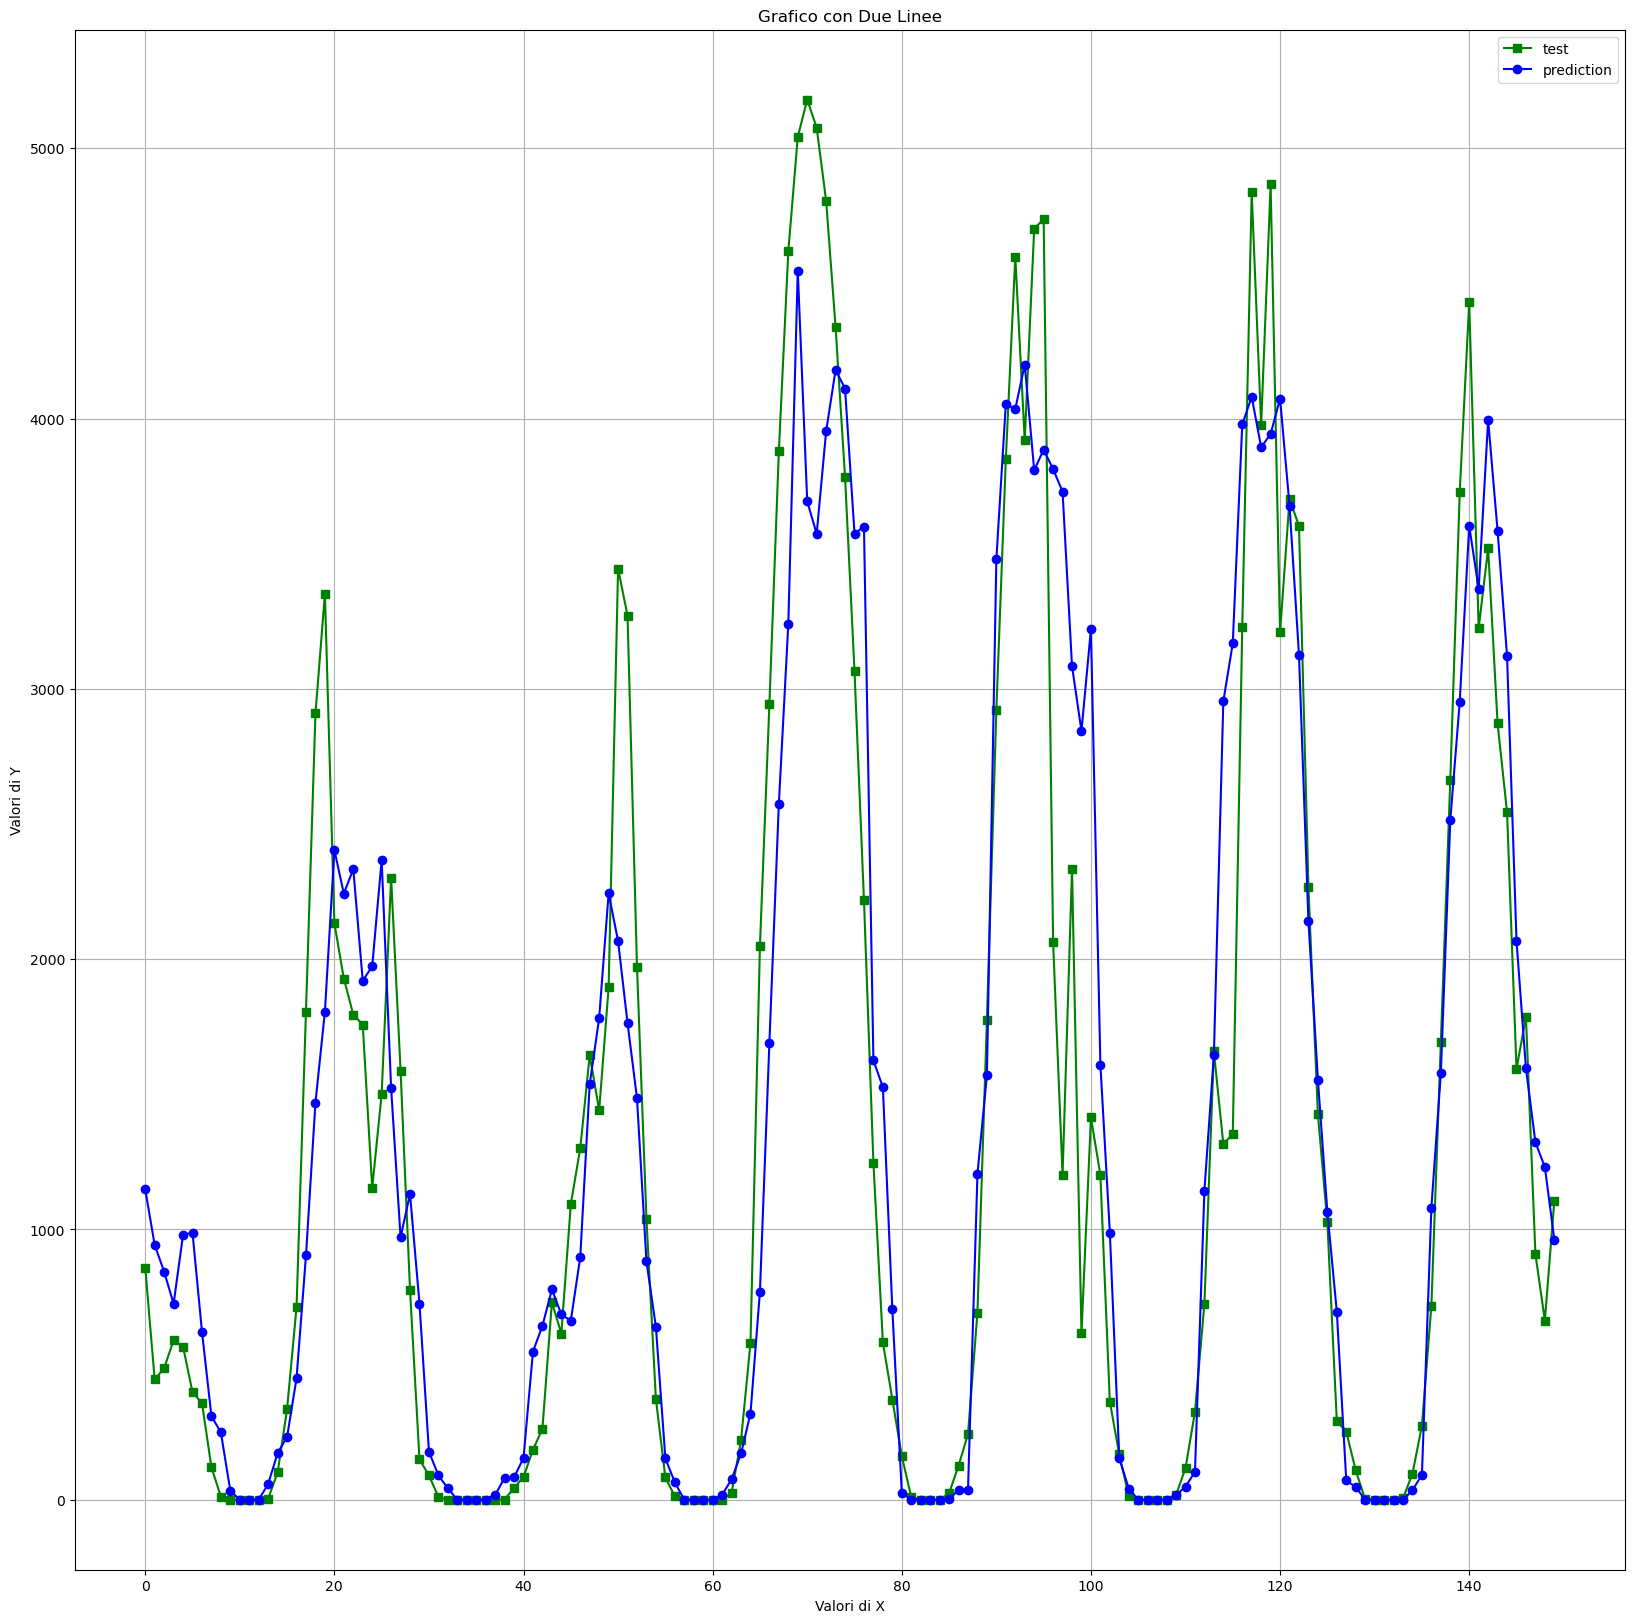

In [216]:
plt.figure(figsize=(20, 20))
plt.plot(y_test[50:200], label='test', color='g', marker='s')
plt.plot(forest_pca_test_predictions[50:200], label='prediction', color='b', marker='o')


# Aggiungi titoli ed etichette
plt.title('Grafico con Due Linee')
plt.xlabel('Valori di X')
plt.ylabel('Valori di Y')

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()